# Insertion algorithm 

In [2]:
%matplotlib inline

import numpy as np
import os 
import math 
import matplotlib.pyplot as plt
import matplotlib
import sys 
import torch 
import seaborn as sns

print(torch.__version__)

import signatory
import itertools
import cvxpy as cp

1.5.0


In [3]:
test_tensor = torch.rand((3,3,3))
print(test_tensor)

print(test_tensor[0,1,2])

tensor([[[0.1272, 0.6284, 0.0698],
         [0.2328, 0.9630, 0.2013],
         [0.2903, 0.5839, 0.4358]],

        [[0.2084, 0.0924, 0.9747],
         [0.7882, 0.9625, 0.7568],
         [0.4360, 0.6920, 0.8428]],

        [[0.6211, 0.3837, 0.3806],
         [0.6960, 0.8902, 0.4029],
         [0.0921, 0.7900, 0.9720]]])
tensor(0.2013)


## Insertion operator 

In [4]:
test_path = torch.rand((1,10,5))

print(test_path)

tensor([[[0.8649, 0.7639, 0.0623, 0.1942, 0.6234],
         [0.0337, 0.4736, 0.4697, 0.5001, 0.0115],
         [0.5237, 0.8341, 0.0284, 0.3964, 0.8525],
         [0.6540, 0.2371, 0.3905, 0.0545, 0.1038],
         [0.7031, 0.5108, 0.1251, 0.2757, 0.0771],
         [0.3394, 0.0353, 0.5605, 0.5852, 0.3924],
         [0.4555, 0.2766, 0.7625, 0.7501, 0.0923],
         [0.5546, 0.1430, 0.7666, 0.3149, 0.9374],
         [0.5925, 0.0386, 0.6359, 0.4626, 0.6174],
         [0.0560, 0.7619, 0.6528, 0.1939, 0.8255]]])


In [5]:
signature_test = signatory.signature(test_path, 2)
print(signature_test.size())

torch.Size([1, 30])


In [6]:
def get_signature_as_tensor(sig,dimension,order):
    
    ''' This function transforms a signature given as a vector into a series of tensors, 
    stored in a dictionnary. It uses the method extract_signature_term() of Signatory. 
    
    For instance, for a path in R^d, the key called 'Depth z' is a Pytorch tensor 
    of size (R^d)^{\otimes z}.
    
    Arguments that need to be specified are:
        - sig : the original signature
        - dimension : the dimension of the original path
        - order : the order (or total depth) at which the original signature is calculated.
    
    '''
    
    total_tensor = {}
    
    for depth in np.arange(1,order+1):
        
        signature_at_depth = signatory.extract_signature_term(sig,dimension,int(depth))
        
        tensor_size = [dimension]*int(depth)
        
        signature_at_depth = signature_at_depth.view(tensor_size)
        
        total_tensor["Depth " + str(depth)] = signature_at_depth
        
    return total_tensor      

In [7]:
get_signature_as_tensor(signature_test,5,2)

{'Depth 1': tensor([-8.0885e-01, -1.9810e-03,  5.9048e-01, -3.3808e-04,  2.0213e-01]),
 'Depth 2': tensor([[ 3.2712e-01, -2.3880e-01, -1.7768e-01,  6.2242e-02, -3.1848e-01],
         [ 2.4040e-01,  1.9968e-06, -2.4669e-01, -5.3880e-02, -1.2327e-01],
         [-2.9992e-01,  2.4552e-01,  1.7433e-01, -1.4613e-01,  3.3577e-01],
         [-6.1968e-02,  5.3880e-02,  1.4593e-01,  5.9605e-08,  2.8139e-01],
         [ 1.5498e-01,  1.2287e-01, -2.1642e-01, -2.8145e-01,  2.0428e-02]])}

In [8]:
def Insertion(p,n,x,signature,dimension):
    
    '''This function computes the Insertion operator taken at x, for parameters p and n.
    
    Arguments : 
    
        - x : vector in R^dimension at which the operator should be evaluated.
        - p : insertion spot. 
        - n : total depth of the signature.
        - signature : total signature of a path
        - dimension : dimension of the path.
    '''
    
    #Get the last (n-th) term of the signature as a tensor of size (R^dimension)^{\otimes n}
    
    last_signature_term = get_signature_as_tensor(signature,dimension,n)["Depth "+ str(n)]
    
    #Add a dimension, since the output of the operator should be in (R^d)^{\otimes (n+1)}
    
    new_tensor = new_tensor=torch.empty([dimension]*(n+1))
    
    #Creates a list containing all possible coordinates of the big tensor.
    #This list is of length dimension**n. 
    
    tensor_size = np.arange(dimension)
    
    coordinates_list = list(itertools.product(tensor_size,repeat= n+1))
    
    
    #Every element of coordinates_list is a coordinate of the new tensor, which has d^(n+1) coordinates.
    
    #Computes the Insertion operator.
    
    for coordinate in coordinates_list:
        
        coordinate = list(coordinate)
                
        x_coordinate = x[coordinate[p-1]]
        
        new_coordinate = coordinate.copy()
        
        del new_coordinate[p-1]
        
        new_tensor[tuple(coordinate)] = last_signature_term[tuple(new_coordinate)]*x_coordinate
        
        
    return math.factorial(n)*new_tensor

In [9]:
x=[1,2,3,4,5]

p=3

n=2

dimension=5

Insertion(p,n,x,signature_test,dimension)

tensor([[[ 6.5425e-01,  1.3085e+00,  1.9627e+00,  2.6170e+00,  3.2712e+00],
         [-4.7759e-01, -9.5518e-01, -1.4328e+00, -1.9104e+00, -2.3880e+00],
         [-3.5537e-01, -7.1074e-01, -1.0661e+00, -1.4215e+00, -1.7768e+00],
         [ 1.2448e-01,  2.4897e-01,  3.7345e-01,  4.9793e-01,  6.2242e-01],
         [-6.3695e-01, -1.2739e+00, -1.9109e+00, -2.5478e+00, -3.1848e+00]],

        [[ 4.8080e-01,  9.6159e-01,  1.4424e+00,  1.9232e+00,  2.4040e+00],
         [ 3.9935e-06,  7.9870e-06,  1.1981e-05,  1.5974e-05,  1.9968e-05],
         [-4.9338e-01, -9.8677e-01, -1.4802e+00, -1.9735e+00, -2.4669e+00],
         [-1.0776e-01, -2.1552e-01, -3.2328e-01, -4.3104e-01, -5.3880e-01],
         [-2.4655e-01, -4.9310e-01, -7.3965e-01, -9.8620e-01, -1.2327e+00]],

        [[-5.9985e-01, -1.1997e+00, -1.7995e+00, -2.3994e+00, -2.9992e+00],
         [ 4.9104e-01,  9.8209e-01,  1.4731e+00,  1.9642e+00,  2.4552e+00],
         [ 3.4866e-01,  6.9732e-01,  1.0460e+00,  1.3946e+00,  1.7433e+00],
        

In [10]:
def get_length(signature,dimension,order):
    
    '''This function approximates the length of the path through the signature.
    
        Arguments are : 
            - signature : the full signature. 
            - order : the order at which the signature was truncated. 
    
    '''
    
    last_signature_term = signatory.extract_signature_term(signature,dimension,int(order))
    
    return torch.norm(math.factorial(order)*last_signature_term,2)*(1/order)

In [11]:
get_length(signature_test,5,2)

tensor(1.0125)

In [12]:
def get_A_matrix(p,signature,order,dimension):
    
    '''This function creates the matrix lenght_of_path*A, used in the optimization problem.
    
        Arguments: 
            - p : insertion spot.
            - signature : full original signature.
            - order : order of truncation of signature. 
            - dimension : dimension of the path. 
    
    '''
    
    #Create basis of R^d
    
    basis = np.eye(dimension,dimension)
    
    #Evaluate the insertion operator on the basis
    
    total_tensor = np.zeros(shape=(dimension**(order + 1),dimension))
    
    for row in np.arange(dimension):
    
        base_vector = basis[row,:]
        
        insertion_tensor = Insertion(p,order,base_vector,signature,dimension)
        
        insertion_tensor = insertion_tensor.reshape(-1,dimension)
        
        insertion_tensor = insertion_tensor.numpy()
        
        total_tensor[row*(dimension**(order)):(row+1)*(dimension**(order)),:] = insertion_tensor
        
    
    total_tensor = total_tensor.reshape(dimension**(order+1),dimension)
    
    length = get_length(signature,dimension,order)
    
    return length*total_tensor

    


In [13]:
get_A_matrix(1,signature_test,2,5)

tensor([[ 6.6243e-01, -4.8357e-01, -3.5981e-01,  1.2604e-01, -6.4492e-01],
        [ 4.8681e-01,  4.0435e-06, -4.9956e-01, -1.0911e-01, -2.4963e-01],
        [-6.0735e-01,  4.9719e-01,  3.5302e-01, -2.9592e-01,  6.7994e-01],
        [-1.2549e-01,  1.0911e-01,  2.9551e-01,  1.2070e-07,  5.6981e-01],
        [ 3.1385e-01,  2.4882e-01, -4.3825e-01, -5.6995e-01,  4.1367e-02],
        [ 0.0000e+00, -0.0000e+00, -0.0000e+00,  0.0000e+00, -0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00],
        [-0.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00],
        [-0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -0.0000e+00, -0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -0.0000e+00, -0.0000e+00,  0.0000e+00, -0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00],
        [-0.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00],
        [-0.0000e+00,  0.

In [14]:
def solve_optimization_problem(signature,signature_next_step,p,n,dimension):
    
    '''This function solves the optimization problem that allows to approximate the signature 
        of the path. 
        
        Arguments:
            - n : order at which the signature is taken.
            - signature : full signature at order n.
            - signature_next_step : full signature at order n+1 (!).
            - p : insertion spot, determinates the time interval on which the derivative is approximated. 
            - dimension : dimension of the path.
    '''
    
    #Create A matrix and b vector used in the optimization problem. 
    
    A_matrix = np.array(get_A_matrix(p,signature,n,dimension))
    
    b_vector = np.array(signatory.extract_signature_term(signature_next_step,dimension,int(n+1)))
    
    b_vector = b_vector.flatten()
    
    #SVD 
    
    U,Sigma,V = np.linalg.svd(A_matrix,full_matrices=True)
    
    Y = U@b_vector 
    
    #Only take the d-first values of Y
    
    Y = Y[0:dimension]
    
    #Compute optimal x
    
    x = (1/np.linalg.norm(Y))*Y
    
    x_optimal = (V.T)@(V)@x
    
    return x_optimal  

In [15]:
signature = signatory.signature(test_path, 2)
signature_next = signatory.signature(test_path,3)

solve_optimization_problem(signature, signature_next,p=2,n=2,dimension=5)

array([-0.01928678,  0.88088377,  0.47067782, -0.04576185,  0.00632765])

## Tests

### Tests on semi-circle 

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


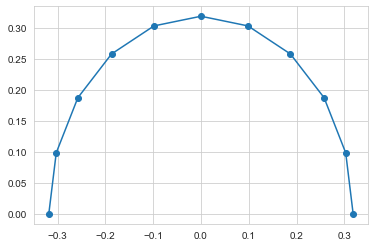

In [16]:
points = np.arange(0,1.1,0.1)

print(points)

x1 = 1/(math.pi)*np.cos(math.pi*points)

x2 = 1/(math.pi)*np.sin(math.pi*points)

sns.set_style('whitegrid')

plt.plot(x1,x2,linestyle='-',marker='o')
plt.show()

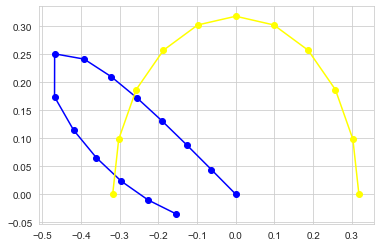

In [33]:
path = torch.tensor(np.array((x1,x2)).T)

k=13

signature = signatory.signature(path.unsqueeze(0), k)
signature_next = signatory.signature(path.unsqueeze(0), k+1)

reconstructed_path_derivatives = np.zeros(shape=(2,k))

reconstructed_path = np.zeros(shape=(2,k+1))

for p in np.arange(1,k+1):

    x_optimal = solve_optimization_problem(signature, signature_next,p,n=k,dimension=2)
    
    reconstructed_path_derivatives[:,p-1] = x_optimal 
    
    reconstructed_path[:,p] = reconstructed_path[:,p-1] + reconstructed_path_derivatives[:,p-1]*(1/k)
    
plt.plot(reconstructed_path[0,:],reconstructed_path[1,:],c='blue',marker='o')
plt.plot(x1,x2,linestyle='-',marker='o',c='yellow')
plt.show()
    